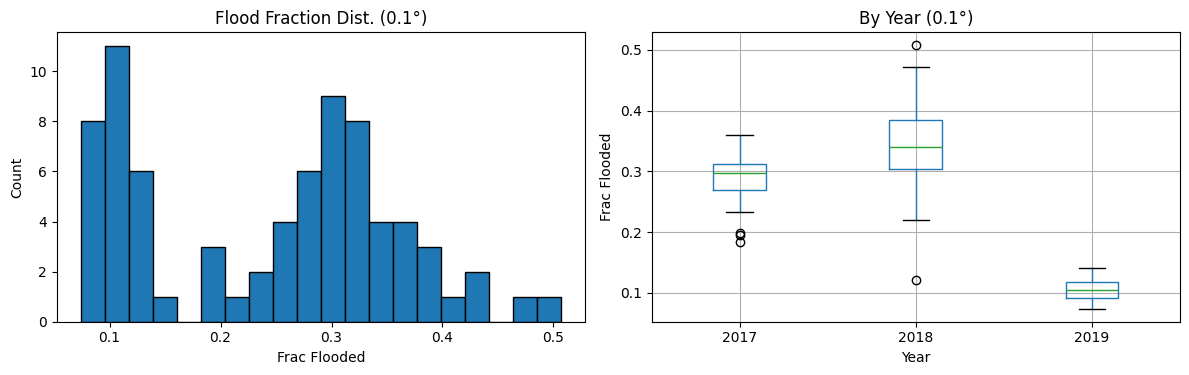

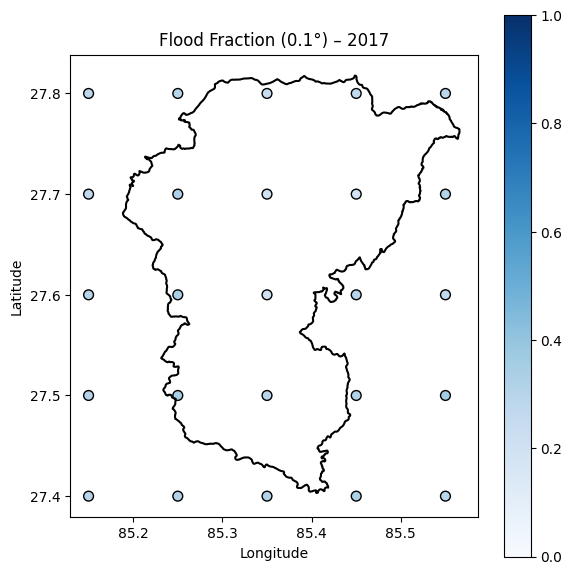

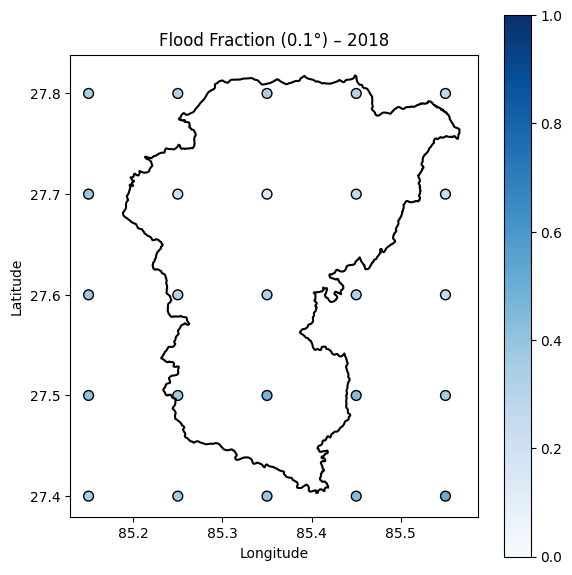

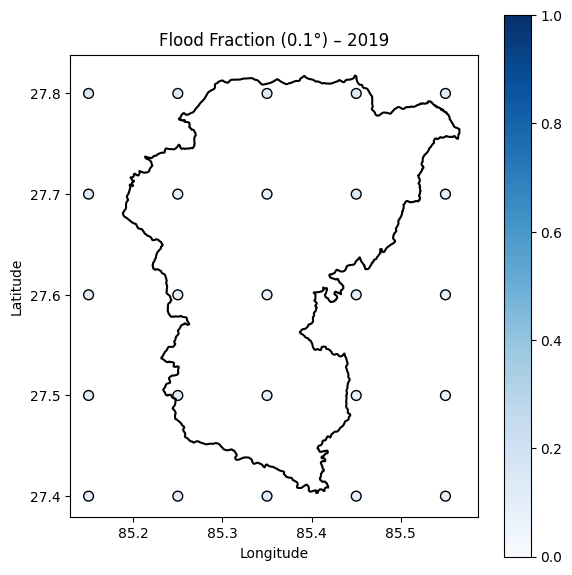

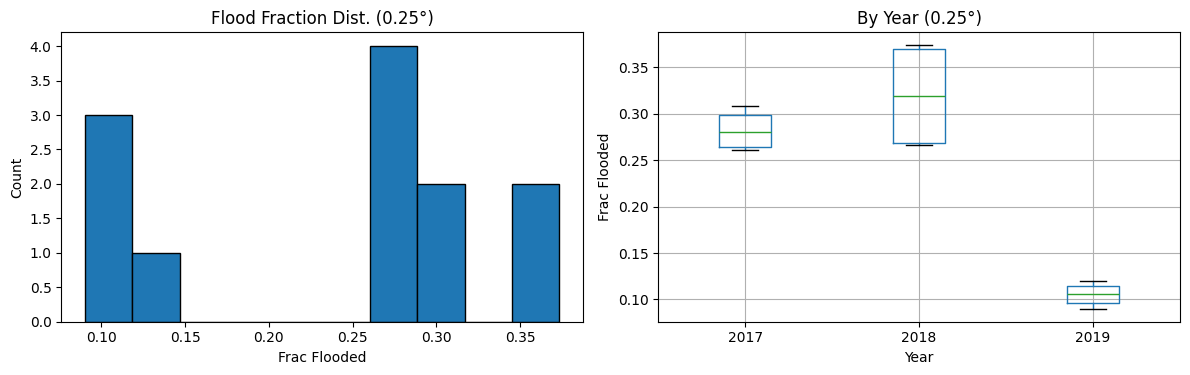

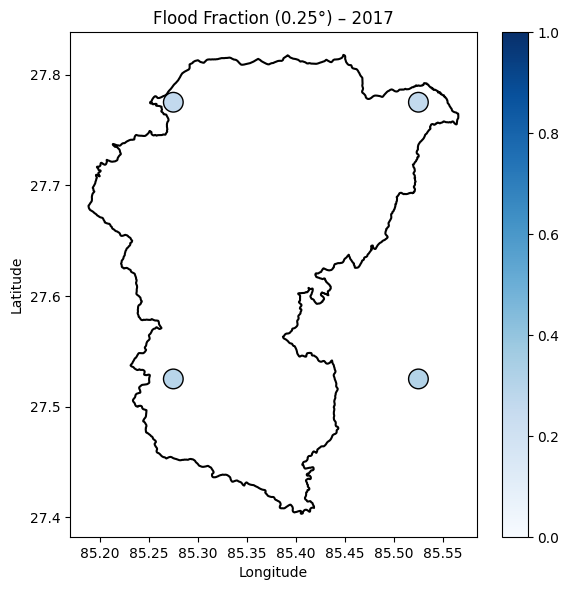

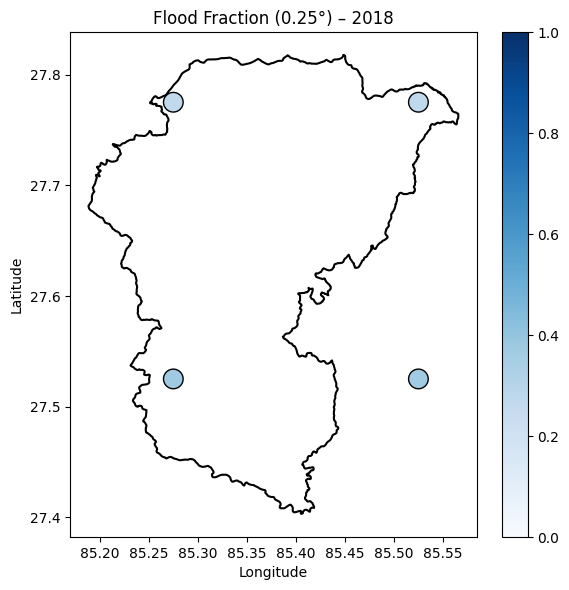

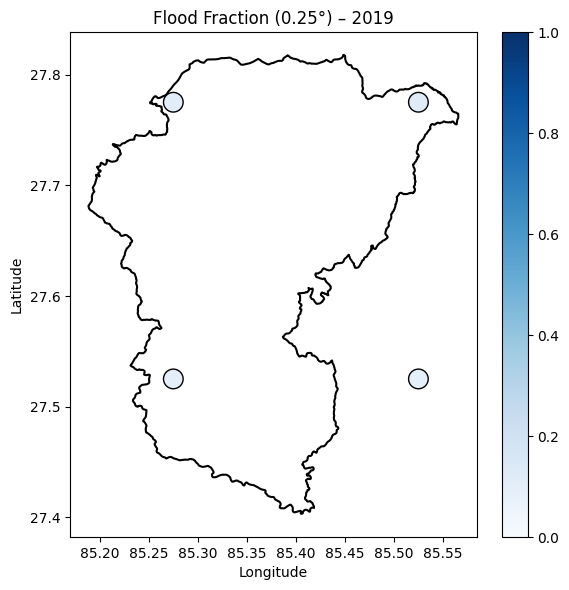

In [6]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path

# ─── CONFIGURATION ────────────────────────────────────────────────
DATA_DIR    = Path('/content/drive/MyDrive/Flood_Thesis/Data')
FLOOD_DIR   = DATA_DIR / 'Flood_labels'
SHAPEFILE   = DATA_DIR / 'kathmandu valley border' / 'kathmandu valley border.shp'
YEARS       = [2017, 2018, 2019]

# Load 0.1° tile centers from your static CSV
static_dir  = DATA_DIR / 'static_data'
fine_centers = pd.read_csv(static_dir / 'slope_0.1deg.csv')[['lat_center','lon_center']]

# Define 0.25° tile centers
coarse_lats   = [27.525, 27.775]
coarse_lons   = [85.275, 85.525]
coarse_centers = pd.DataFrame([
    {'lat_center':lat,'lon_center':lon}
    for lat in coarse_lats for lon in coarse_lons
])

# Load Kathmandu boundary
valley = gpd.read_file(SHAPEFILE).to_crs(epsg=4326)

all_fine, all_coarse = [], []

for year in YEARS:
    # 1) Read the yearly flood mask (0/1) as a NumPy array
    path = FLOOD_DIR / f"flood_label_{year}.tif"
    with rasterio.open(path) as src:
        data = src.read(1)
        h, w = data.shape
        rows = np.arange(h); cols = np.arange(w)
        cols2d, rows2d = np.meshgrid(cols, rows)
        lons2d, lats2d = rasterio.transform.xy(src.transform, rows2d, cols2d)
        lons2d = np.array(lons2d); lats2d = np.array(lats2d)
    flat_data = data.ravel()

    # 2) Compute flood fraction per 0.1° tile
    for _, r in fine_centers.iterrows():
        latc, lonc = r.lat_center, r.lon_center
        mask = ((lats2d >= latc-0.05) & (lats2d < latc+0.05) &
                (lons2d >= lonc-0.05) & (lons2d < lonc+0.05))
        flat_mask = mask.ravel()
        frac = flat_data[flat_mask].sum() / flat_mask.sum()
        all_fine.append({'year':year,'lat_center':latc,'lon_center':lonc,'frac_flooded':frac})

    # 3) Compute flood fraction per 0.25° tile
    for _, r in coarse_centers.iterrows():
        latc, lonc = r.lat_center, r.lon_center
        mask = ((lats2d >= latc-0.125) & (lats2d < latc+0.125) &
                (lons2d >= lonc-0.125) & (lons2d < lonc+0.125))
        flat_mask = mask.ravel()
        frac = flat_data[flat_mask].sum() / flat_mask.sum()
        all_coarse.append({'year':year,'lat_center':latc,'lon_center':lonc,'frac_flooded':frac})

# Build DataFrames
fine_df   = pd.DataFrame(all_fine)
coarse_df = pd.DataFrame(all_coarse)


# ─── VISUALIZATION for 0.1° GRID ──────────────────────────────────
# Distribution + boxplot
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(fine_df['frac_flooded'], bins=20, edgecolor='black')
axes[0].set(title="Flood Fraction Dist. (0.1°)", xlabel="Frac Flooded", ylabel="Count")
fine_df.boxplot(column='frac_flooded', by='year', ax=axes[1])
axes[1].set(title="By Year (0.1°)", xlabel="Year", ylabel="Frac Flooded")
plt.suptitle(''); plt.tight_layout(); plt.show()

# Spatial maps
gdf_fine = gpd.GeoDataFrame(
    fine_df,
    geometry=[Point(lon,lat) for lon,lat in zip(fine_df.lon_center, fine_df.lat_center)],
    crs='EPSG:4326'
)
for year in YEARS:
    fig, ax = plt.subplots(figsize=(6,6))
    valley.boundary.plot(ax=ax, edgecolor='black')
    gdf_fine[gdf_fine.year==year].plot(
        ax=ax, column='frac_flooded', cmap='Blues', vmin=0, vmax=1,
        legend=True, markersize=50, edgecolor='k'
    )
    ax.set(title=f"Flood Fraction (0.1°) – {year}",
           xlabel="Longitude", ylabel="Latitude")
    plt.tight_layout(); plt.show()


# ─── VISUALIZATION for 0.25° GRID ─────────────────────────────────
# Distribution + boxplot
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(coarse_df['frac_flooded'], bins=10, edgecolor='black')
axes[0].set(title="Flood Fraction Dist. (0.25°)", xlabel="Frac Flooded", ylabel="Count")
coarse_df.boxplot(column='frac_flooded', by='year', ax=axes[1])
axes[1].set(title="By Year (0.25°)", xlabel="Year", ylabel="Frac Flooded")
plt.suptitle(''); plt.tight_layout(); plt.show()

# Spatial maps
gdf_coarse = gpd.GeoDataFrame(
    coarse_df,
    geometry=[Point(lon,lat) for lon,lat in zip(coarse_df.lon_center, coarse_df.lat_center)],
    crs='EPSG:4326'
)
for year in YEARS:
    fig, ax = plt.subplots(figsize=(6,6))
    valley.boundary.plot(ax=ax, edgecolor='black')
    gdf_coarse[gdf_coarse.year==year].plot(
        ax=ax, column='frac_flooded', cmap='Blues', vmin=0, vmax=1,
        legend=True, markersize=200, edgecolor='k'
    )
    ax.set(title=f"Flood Fraction (0.25°) – {year}",
           xlabel="Longitude", ylabel="Latitude")
    plt.tight_layout(); plt.show()


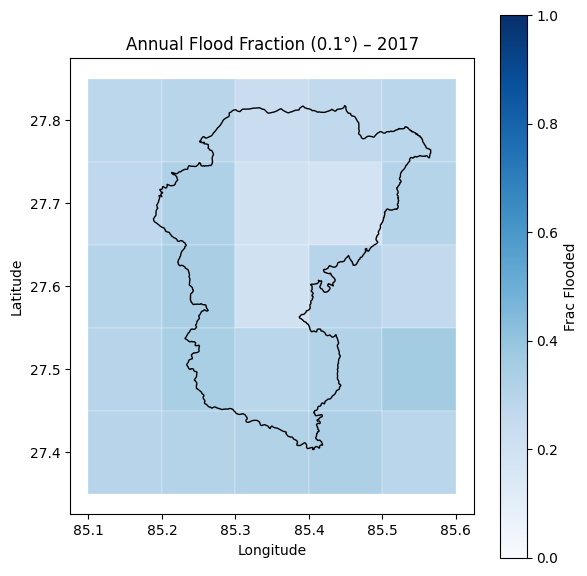

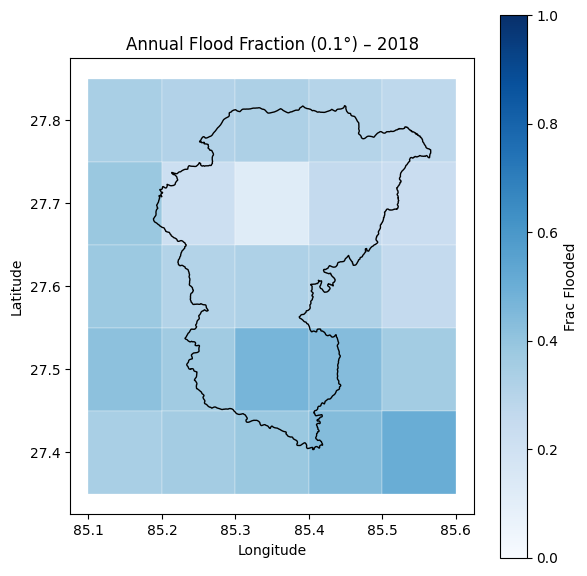

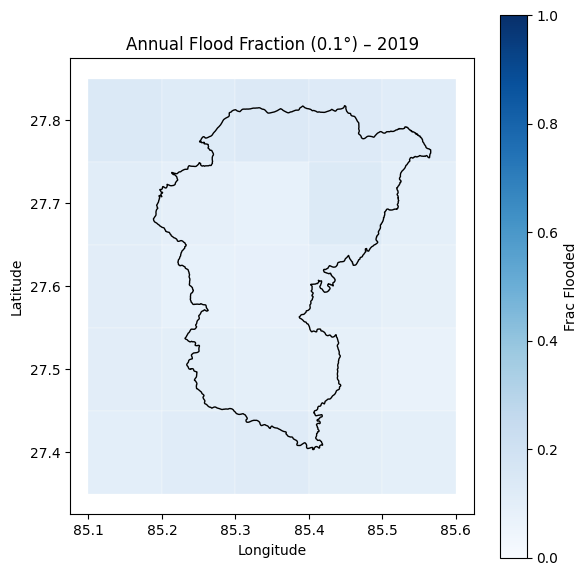

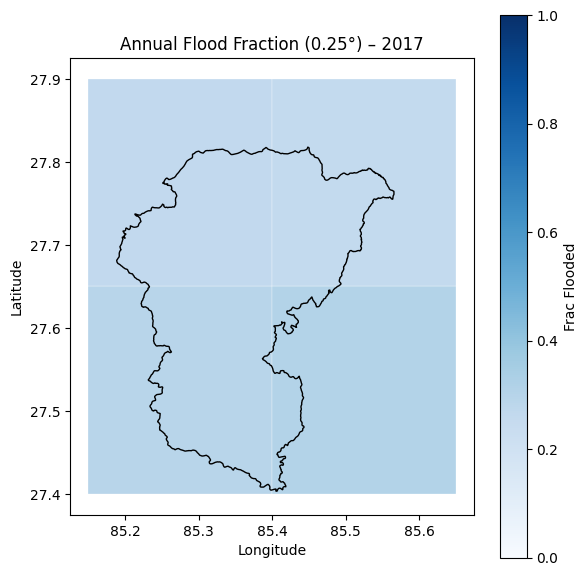

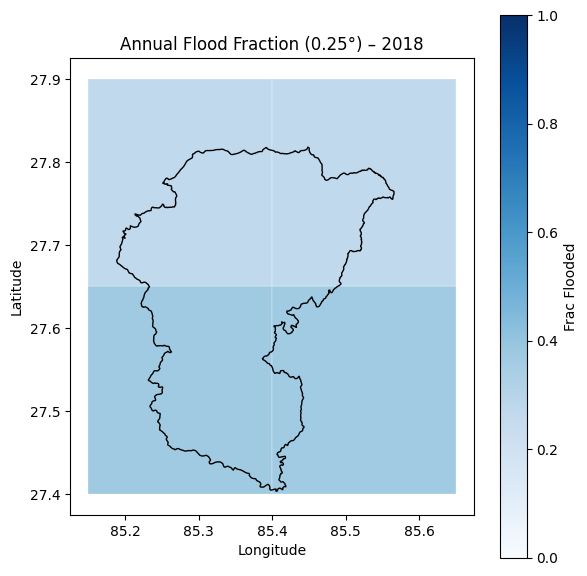

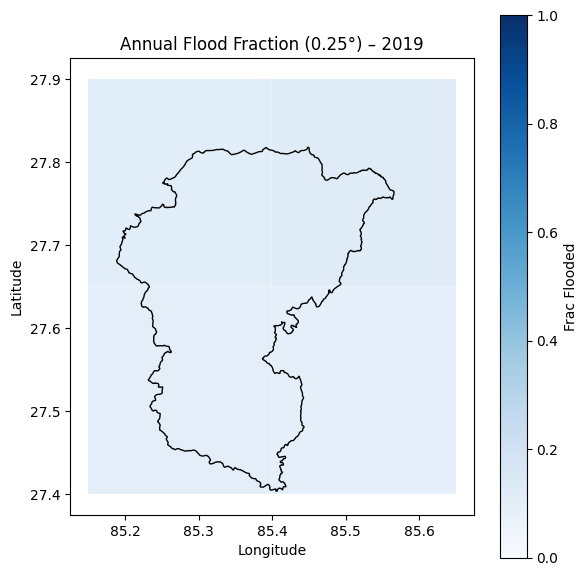

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# --- assume fine_df and coarse_df are already computed as above,
#     and `valley` is your Kathmandu boundary GeoDataFrame ---

# 1) Build GeoDataFrame of 0.1° tiles (each 0.1° × 0.1°)
half = 0.05
fine_gdf = gpd.GeoDataFrame(
    fine_df,
    geometry=[
        box(lon-half, lat-half, lon+half, lat+half)
        for lon, lat in zip(fine_df.lon_center, fine_df.lat_center)
    ],
    crs='EPSG:4326'
)

# 2) Plot full-tile maps for 0.1°
for year in YEARS:
    fig, ax = plt.subplots(figsize=(6,6))
    valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    fine_gdf[fine_gdf.year == year].plot(
        ax=ax,
        column='frac_flooded',
        cmap='Blues',
        vmin=0,
        vmax=1,
        edgecolor='white',
        linewidth=0.2,
        legend=True,
        legend_kwds={'label':'Frac Flooded'}
    )
    ax.set_title(f"Annual Flood Fraction (0.1°) – {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    plt.show()

# 3) Build GeoDataFrame of 0.25° tiles (each 0.25° × 0.25°)
half25 = 0.125
coarse_gdf = gpd.GeoDataFrame(
    coarse_df,
    geometry=[
        box(lon-half25, lat-half25, lon+half25, lat+half25)
        for lon, lat in zip(coarse_df.lon_center, coarse_df.lat_center)
    ],
    crs='EPSG:4326'
)

# 4) Plot full-tile maps for 0.25°
for year in YEARS:
    fig, ax = plt.subplots(figsize=(6,6))
    valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    coarse_gdf[coarse_gdf.year == year].plot(
        ax=ax,
        column='frac_flooded',
        cmap='Blues',
        vmin=0,
        vmax=1,
        edgecolor='white',
        linewidth=0.2,
        legend=True,
        legend_kwds={'label':'Frac Flooded'}
    )
    ax.set_title(f"Annual Flood Fraction (0.25°) – {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    plt.show()
